# Лабораторная работа № 5(1)
Группа: М8О-407Б-18

Студент: Бердикин Т.А.  


Подключим всё необходимое

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Загрузим датасет. Обратите внимание, что датасет необходимо закинуть на гугл диск перед запуском. Путь корректируется. Из датасета заранее убраны ручками все лишние классы и оставлены только киви и картошка -- с ними интереснее, так как они сильно похожи друг на друга.

https://www.kaggle.com/datasets/sshikamaru/fruit-recognition



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#    print('User uploaded file "{name}" with length {length} bytes'.format(
#        name=fn, length=len(uploaded[fn])))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_transform = transforms.Compose([      # Composes several transforms together.
        transforms.RandomResizedCrop(224), # Crop a random portion of image and resize it to a given size.
        transforms.RandomHorizontalFlip(), # Random horizontal flim w/ probobility 0.5 . 
        transforms.ToTensor(),             # Convert a PIL Image or numpy.ndarray to tensor. 
        # Normalize image for given mean and std.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = '/content/gdrive/MyDrive/fruit/train'

# data_dir = '/fruit/train'
dataset = datasets.ImageFolder(data_dir, data_transform)
class_names = dataset.classes

coef= 0.75
split_sizes = [
  int(coef*len(dataset)),
  len(dataset) - int(coef*len(dataset))
]

image_datasets = {}

image_datasets['train'], image_datasets['val'] = torch.utils.data.random_split(dataset, split_sizes, generator=torch.Generator().manual_seed(42))


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
image_datasets['train']

Визуализируем некоторые изображения из датасета

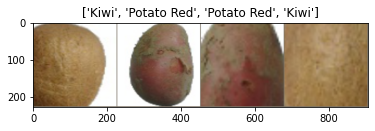

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Обучим модель

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2342 Acc: 0.9098
val Loss: 0.0066 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.2772 Acc: 0.9039
val Loss: 0.0604 Acc: 0.9825

Epoch 2/24
----------
train Loss: 0.2094 Acc: 0.9360
val Loss: 0.0070 Acc: 0.9956

Epoch 3/24
----------
train Loss: 0.2337 Acc: 0.9374
val Loss: 0.0085 Acc: 0.9956

Epoch 4/24
----------
train Loss: 0.3165 Acc: 0.9243
val Loss: 0.0212 Acc: 0.9913

Epoch 5/24
----------
train Loss: 0.1877 Acc: 0.9418
val Loss: 0.0038 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.2247 Acc: 0.9243
val Loss: 0.0245 Acc: 0.9869

Epoch 7/24
----------
train Loss: 0.1593 Acc: 0.9432
val Loss: 0.0008 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0990 Acc: 0.9607
val Loss: 0.0053 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1356 Acc: 0.9301
val Loss: 0.0013 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1100 Acc: 0.9607
val Loss: 0.0024 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1244 Acc: 0.9418
val Loss: 0.0029 Acc: 1.0000

Ep

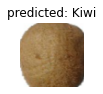

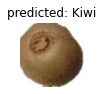

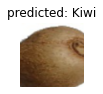

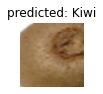

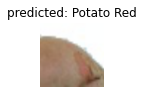

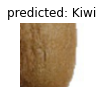

In [ ]:
visualize_model(model_ft)

Модель обучилась менее чем за 7 минут, классифицирует изображения правильно, нареканий нет.

Попробуем на этот раз изменять веса финального слоя

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3647 Acc: 0.8341
val Loss: 0.0320 Acc: 0.9913

Epoch 1/24
----------
train Loss: 0.3440 Acc: 0.8690
val Loss: 0.0131 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.2417 Acc: 0.8923
val Loss: 0.0066 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.2168 Acc: 0.9156
val Loss: 0.0422 Acc: 0.9825

Epoch 4/24
----------
train Loss: 0.1829 Acc: 0.9199
val Loss: 0.0095 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2702 Acc: 0.8850
val Loss: 0.0144 Acc: 0.9956

Epoch 6/24
----------
train Loss: 0.1880 Acc: 0.9301
val Loss: 0.0111 Acc: 0.9956

Epoch 7/24
----------
train Loss: 0.2142 Acc: 0.8894
val Loss: 0.0098 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1685 Acc: 0.9156
val Loss: 0.0067 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1677 Acc: 0.9199
val Loss: 0.0065 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1881 Acc: 0.9199
val Loss: 0.0032 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1815 Acc: 0.9272
val Loss: 0.0065 Acc: 1.0000

Ep

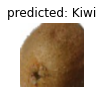

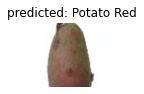

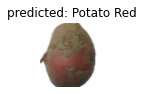

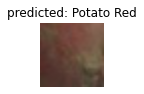

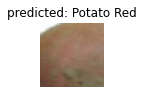

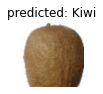

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Как видно, данное решение позволило ускорить обучение практически в три раза!
При этом классификация происходит так же быстро.

# Реализация собственного датасета

Наш класс будет просто наследоваться от datasets.DatasetFolder

In [ ]:
from PIL import Image
from traitlets.traitlets import default

def pil_loader(path: str) -> Image.Image:
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def default_loader(path: str) :
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)


image_extantion = ('.jpg', '.jpeg', '.png')

#вообще image_extantion здесь не сильно нужен, т.к. у нас все изображения имеют формат jpg, но придётся оставить из-за требований наследуемого класса

class MyDataset(datasets.DatasetFolder):
    
    def __init__(self, root: str, transform=None, target_transform=None, loader=default_loader, is_valid_file=None):
        super(MyDataset, self).__init__(root, loader, image_extantion if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        self.imgs = self.samples

Загрузим данные

In [ ]:
dataset = MyDataset(data_dir, data_transform)

class_names = dataset.classes


coef= 0.75
split_sizes = [
  int(coef*len(dataset)),
  len(dataset) - int(coef*len(dataset))
]

image_datasets = {}

image_datasets['train'], image_datasets['val'] = torch.utils.data.random_split(dataset, split_sizes, generator=torch.Generator().manual_seed(1337))


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

Загрузим и обучим модель

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4304 Acc: 0.7991
val Loss: 0.0273 Acc: 0.9913

Epoch 1/24
----------
train Loss: 0.3146 Acc: 0.8763
val Loss: 0.0443 Acc: 0.9869

Epoch 2/24
----------
train Loss: 0.1920 Acc: 0.9112
val Loss: 0.0118 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.2465 Acc: 0.8908
val Loss: 0.0072 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.2327 Acc: 0.9083
val Loss: 0.0152 Acc: 0.9956

Epoch 5/24
----------
train Loss: 0.2362 Acc: 0.9068
val Loss: 0.0057 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.3315 Acc: 0.8923
val Loss: 0.0154 Acc: 0.9956

Epoch 7/24
----------
train Loss: 0.2376 Acc: 0.8996
val Loss: 0.0115 Acc: 0.9956

Epoch 8/24
----------
train Loss: 0.1589 Acc: 0.9330
val Loss: 0.0141 Acc: 0.9956

Epoch 9/24
----------
train Loss: 0.1904 Acc: 0.9272
val Loss: 0.0025 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1595 Acc: 0.9403
val Loss: 0.0037 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1424 Acc: 0.9418
val Loss: 0.0069 Acc: 1.0000

Ep

Результат практически идентичен предыдущему

# MyConvNet

У нас было две свёртки, аулинг, три полносвязных слоя, запись лабораторной и юпитер ноутбук, а также пара дней до дедлайна. Не то чтобы это всё было категорически необходимо, но если уж начал делать лабы в последний момент, становится сложно остановиться.

Итак, наша сеть:

In [ ]:
import torch.nn.functional as F

class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 0/24
----------
train Loss: 0.1514 Acc: 0.9360
val Loss: 0.0130 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.2023 Acc: 0.9199
val Loss: 0.0077 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.1550 Acc: 0.9170
val Loss: 0.0125 Acc: 0.9956

Epoch 3/24
----------
train Loss: 0.1859 Acc: 0.9258
val Loss: 0.0147 Acc: 0.9956

Epoch 4/24
----------
train Loss: 0.1666 Acc: 0.9287
val Loss: 0.0149 Acc: 0.9956

Epoch 5/24
----------
train Loss: 0.1613 Acc: 0.9301
val Loss: 0.0112 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1466 Acc: 0.9360
val Loss: 0.0092 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1922 Acc: 0.9229
val Loss: 0.0097 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1564 Acc: 0.9374
val Loss: 0.0194 Acc: 0.9956

Epoch 9/24
----------
train Loss: 0.1425 Acc: 0.9389
val Loss: 0.0089 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1383 Acc: 0.9418
val Loss: 0.0199 Acc: 0.9956

Epoch 11/24
----------
train Loss: 0.1467 Acc: 0.9374
val Loss: 0.0133 Acc: 1.0000

Ep

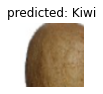

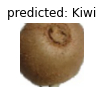

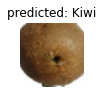

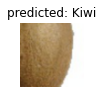

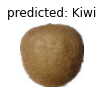

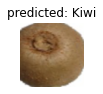

In [ ]:
my_model = MyConvNet()

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()

Можно видеть, что результат нашей модели практически полностью идентичен предыдущему, т.е. она сделана качественно, хоть и задача была сложная, потому что картошка и киви на фотографиях сильно похожи друг на друга.